In [46]:
%cd /data/bruingjde/on-going/SNAM2021-code/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.metrics
import sklearn.linear_model
import seaborn as sns
from tqdm.auto import tqdm

networks = [network for network in np.arange(1, 31) if network not in [15, 17, 26, 27]]

def get_performance(network: int, nswap_perc: int = 0, feature_set: str = 'II-A', model: str = 'LogisticRegression'):
    with open(f'data/{network:02}/{nswap_perc:+04.0f}/properties/{feature_set}_{model}.float') as file:
        return float(file.read())
    
def read_file(path):
    extension = path.split('.')[1]
    if extension == 'int':
        with open(path) as file:
            return int(file.read())
    elif extension == 'float':
        with open(path) as file:
            return float(file.read())
    else:
        raise Exception(f'{extension=}')

def get_stats(network: int):
    properties_dir = f'data/{network:02}/+000/properties/'
    properties = {prop.split('.')[0]: read_file(properties_dir + prop) 
                  for prop 
                  in ['nodes.int', 'edges.int', 'connected_pairs.int', 'edges.int', 
                      'assortativity.float', 'average_clustering.float', 'diameter.int']}
    info = pd.read_json('networks.jsonl', lines=True).set_index('index').loc[network]
    return {
        'Label': info['label'],
        'Domain': info['category'],
        '\\bar e': properties['edges'] / properties['connected_pairs'],
        'Nodes': properties['nodes'], 
        'Edges': properties['edges'],
        'Density': 2*properties['connected_pairs'] / (properties['nodes']*(properties['nodes'] - 1)),
        'Assortativity': properties['assortativity'],
        'Average clustering coefficient': properties['average_clustering'],
        'Diameter': properties['diameter'],
        '': '\cite{' + info['source'] + '}' #type: ignore
    }

info = pd.read_json('networks.jsonl', lines=True).set_index('index')
table = pd.DataFrame({network: get_stats(network) for network in networks}).T
df = pd.DataFrame({
    'number of nodes': table['Nodes'].astype(int),
    'number of edges': table['Edges'].astype(float),
    'density': table['Density'].astype(float),
    'degree assortativity': table['Assortativity'].astype(float),
    'average clustering coefficient': table['Average clustering coefficient'].astype(float),
    'diameter': table['Diameter'].astype(int),
    'Static topological features (AUC)': {network: get_performance(network, feature_set='I') for network in networks},
    'Temporal topological features (AUC)': {network: get_performance(network, feature_set='II-A') for network in networks},
}).dropna()

/data/bruingjde/on-going/SNAM2021-code


In [48]:
data = (
    df
    .corr()
    .loc[['number of nodes', 'number of edges', 'density', 'degree assortativity',
          'average clustering coefficient', 'diameter'], 
         ['Static topological features (AUC)', 'Temporal topological features (AUC)']]
)
data

,Static topological features (AUC),Temporal topological features (AUC)
number of nodes,0.037187,0.069971
number of edges,-0.074680,-0.021758
density,-0.376789,-0.259893
degree assortativity,-0.650712,-0.716001
average clustering coefficient,-0.640699,-0.504401
diameter,0.091873,0.047331


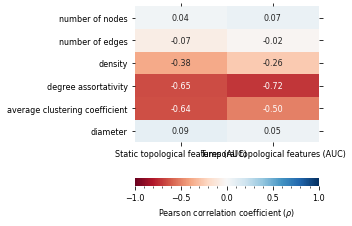

In [53]:
fontsize=8
grid_kws = {"height_ratios": (.9, .05), "hspace": .5}
rc = {
  'xtick.top': True, 'ytick.right': True, 'figure.figsize': (3.30,3.3), 
  'axes.titlesize': fontsize, 
  'axes.labelsize': fontsize, 
  'xtick.labelsize': fontsize, 
  'ytick.labelsize': fontsize, 
  'legend.fontsize': fontsize, 
  'legend.title_fontsize': fontsize,
  'lines.linewidth': 1,
#   'lines.markersize': 4,
  'legend.handlelength': .1,
  'font.family': 'sans-serif',
  'font.sans-serif': 'Helvetica',
  'savefig.transparent': True
}

with plt.rc_context(rc):
    f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.3, 3.3))
    ax = sns.heatmap(data, ax=ax, cbar_ax=cbar_ax,
                     cbar_kws={
                         "orientation": "horizontal", 
                         'label': r'Pearson correlation coefficient ($\rho$)'
                     },
                     vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='RdBu',
                     annot_kws={'size': fontsize})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    cbar_ax.xaxis.set_ticks(np.arange(-1, 1.1, .5))
    cbar_ax.xaxis.set_ticks(np.arange(-1, 1.1, .1), minor=True)
#   plt.savefig('code/figures/output/Fig4.pdf', bbox_inches='tight')